# Preparation

In [1]:
seed_value= 42

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
num_epochs  = 20
batch_size  = 32
num_classes = 10
shape       = (28, 28, 1)
lr          = 0.0003
opt         = keras.optimizers.Adam(learning_rate=lr)
los         = keras.losses.BinaryCrossentropy(from_logits=True)
latent_dim  = 28

# Dataset

In [5]:
def prepare_data(iteration, main_path, generated_path, replace):
    with np.load(main_path) as data:
        x_train, y_train = data['x_train'], data['y_train']
    
    if iteration == 0:
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        y_train = keras.utils.to_categorical(y_train, 10)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
    elif iteration == 6:
        with np.load(generated_path) as extra:
            extra_images, extra_labels = extra["images"], extra["labels"]
        
        if replace:
            x_train = extra_images
        else:
            x_train = np.concatenate((x_train, extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train, 10)
        
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        y_train = extra_labels
        
    else:
        with np.load(generated_path) as extra:
            extra_images, extra_labels = extra["images"], extra["labels"]
        
        if replace:
            added_len = len(extra_images) * -1
            x_train = np.concatenate((x_train[:added_len], extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train[:added_len], 10)
        else:
            x_train = np.concatenate((x_train, extra_images), axis=0)
            y_train = keras.utils.to_categorical(y_train, 10)
        
        x_train = x_train.astype("float32") / 255.0
        x_train = np.reshape(x_train, (-1, 28, 28, 1))
        y_train = np.concatenate((y_train, extra_labels), axis=0)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
            
    print(f"Shape of training images: {x_train.shape}")
    print(f"Shape of training labels: {y_train.shape}")
    
    return train_dataset

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = shape[2] + num_classes   

# Model

In [6]:
def get_models():
    discriminator = keras.Sequential([keras.layers.InputLayer((shape[0], shape[1], discriminator_in_channels)),
                                      layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                                      layers.LeakyReLU(alpha=0.2),
                                      layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                                      layers.LeakyReLU(alpha=0.2),
                                      layers.GlobalMaxPooling2D(),
                                      layers.Dense(1)],
                                     name="discriminator")
    
    generator = keras.Sequential([keras.layers.InputLayer((generator_in_channels,)),
                                  layers.Dense(7 * 7 * generator_in_channels),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Reshape((7, 7, generator_in_channels)),
                                  layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                                  layers.LeakyReLU(alpha=0.2),
                                  layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")],
                                 name="generator")
    
    return discriminator, generator

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, accumulation=False):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.accumulation = accumulation
        self.seed_generator = tf.random.Generator.from_seed(seed_value)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.cubical_layer = CubicalLayer(homology_dimensions=[0, 1, 2])
        
        self.digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
        self.ph_real = {str(i): tf.zeros((0, 2), dtype=tf.float32) for i in range(10)}
        self.ph_fake = {str(i): tf.zeros((0, 2), dtype=tf.float32) for i in range(10)}


    def SWD(self, PD1, PD2, num_projections=50):
        angles = tf.random.uniform([num_projections, 2], minval=-1, maxval=1)
        angles /= tf.norm(angles, axis=-1, keepdims=True)
        
        proj1 = tf.linalg.matmul(PD1, tf.transpose(angles))
        proj2 = tf.linalg.matmul(PD2, tf.transpose(angles))
        
        proj1 = tf.sort(proj1, axis=0)
        proj2 = tf.sort(proj2, axis=0)
        
        target_size = tf.maximum(tf.shape(proj1)[0], tf.shape(proj2)[0])
        proj1 = tf.image.resize(proj1[None, :, :], [target_size, num_projections])[0]
        proj2 = tf.image.resize(proj2[None, :, :], [target_size, num_projections])[0]
    
        return tf.reduce_mean(tf.abs(proj1 - proj2))
    
    
    def process_digit(self, indices, X_real, X_fake):
        real_subset = tf.gather(X_real, indices)
        fake_subset = tf.gather(X_fake, indices)
    
        real_dgms = self.cubical_layer.call(real_subset)
        fake_dgms = self.cubical_layer.call(fake_subset)
        
        real_concat = tf.concat([real_dgms[0][0], real_dgms[1][0], real_dgms[2][0]], axis=0)
        fake_concat = tf.concat([fake_dgms[0][0], fake_dgms[1][0], fake_dgms[2][0]], axis=0)
    
        return real_concat, fake_concat
    
    
    def skip_digit(self):
        return tf.zeros((0, 2), dtype=tf.float32), tf.zeros((0, 2), dtype=tf.float32)


    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, data):
        real_images, one_hot_labels = data
        
        # Reshape and repeat one-hot labels to match the image dimensions
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[real_images.shape[1] * real_images.shape[2]], axis=-1)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, real_images.shape[1], real_images.shape[2], one_hot_labels.shape[-1]))
    
        # Batch size
        batch_size = tf.shape(real_images)[0]
        
        # Generate random latent vectors
        random_latent_vectors = self.seed_generator.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
    
        # Generate fake images
        generated_images = self.generator(random_vector_labels)
    
        # Combine fake and real images with their labels
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
    
        # Labels for discriminator
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
    
        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    
        # Train generator
        misleading_labels = tf.zeros((batch_size, 1))
    
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        
            # Calculate Persistent Homology
            y_train = tf.argmax(one_hot_labels, axis=1)
            X_real = (real_images - tf.reduce_min(real_images)) / (tf.reduce_max(real_images) - tf.reduce_min(real_images))
            X_fake = (fake_images - tf.reduce_min(fake_images)) / (tf.reduce_max(fake_images) - tf.reduce_min(fake_images))
            
            ph_losses = 0
            valid_digits = 0
            for digit in self.digits:
                indices = tf.where(y_train == digit)[:, 0]
                
                if tf.size(indices) == 0:
                    continue
                else:
                    real_concat, fake_concat = self.process_digit(indices, X_real, X_fake)
                
                if self.accumulation:
                    self.ph_real[str(digit)] = tf.concat([self.ph_real[str(digit)], real_concat], axis=0)
                    self.ph_fake[str(digit)] = tf.concat([self.ph_fake[str(digit)], fake_concat], axis=0)
                    ph_losses += self.SWD(self.ph_real[str(digit)], self.ph_fake[str(digit)])
                else:
                    ph_losses += self.SWD(real_concat, fake_concat)
                    
                valid_digits += 1
                
            ph_losses = ph_losses / valid_digits
            
            g_total_loss = g_loss + ph_losses
            
        grads = tape.gradient(g_total_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    
        # Update loss trackers
        self.gen_loss_tracker.update_state(g_total_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "loss": self.gen_loss_tracker.result() + self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Train

In [8]:
def interpolate_class(first_number, second_number, num_interpolation, interpolation_noise, trained_gen):
    first_label = tf.keras.utils.to_categorical([first_number], num_classes)
    second_label = tf.keras.utils.to_categorical([second_number], num_classes)
    
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    percent_second_label = tf.linspace(0.0, 1.0, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    
    interpolation_labels = (first_label * (1 - percent_second_label) + second_label * percent_second_label)

    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], axis=1)

    fake_images = trained_gen(noise_and_labels)

    return fake_images


def plot_generated_samples(first_class, second_class, num_interpolation, interpolation_noise, trained_gen):
    generated_images = interpolate_class(first_class, second_class, num_interpolation, interpolation_noise, trained_gen)
    generated_images = generated_images.numpy() * 255

    plt.figure(figsize=(15, 3))
    for i in range(num_interpolation):
        plt.subplot(1, num_interpolation, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    

def generate_and_save_images(generator, num_images, save_path):
    all_labels = []
    all_generated_images = []
    
    num_batches = int(np.ceil(num_images / batch_size))
    
    for batch_idx in range(num_batches):
        batch_size_actual = min(batch_size, num_images - batch_idx * batch_size)

        random_latent_vectors = tf.random.normal(shape=(batch_size_actual, latent_dim))
        
        random_labels = np.random.randint(0, num_classes, size=batch_size_actual)
        one_hot_labels = tf.keras.utils.to_categorical(random_labels, num_classes=num_classes)
        
        noise_and_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        
        generated_images = generator(noise_and_labels)
        generated_images = generated_images.numpy() * 255
        
        all_labels.append(one_hot_labels)
        all_generated_images.append(generated_images)

    all_generated_images = np.concatenate(all_generated_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    np.savez_compressed(save_path, images=all_generated_images[:, :, :, 0], labels=all_labels)
    print(f"Generated {num_images} images and labels, and saved to {save_path}")

Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 23s 11ms/step - loss: 2.0976 - g_loss: 1.6888 - d_loss: 0.4088
Epoch 2/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.7591 - g_loss: 1.2615 - d_loss: 0.4976
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.7206 - g_loss: 1.1885 - d_loss: 0.5322
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5156 - g_loss: 0.8607 - d_loss: 0.6549
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.4638 - g_loss: 0.7920 - d_loss: 0.6719
Epoch 6/20
1875/1875 [==============================] - 23s 12ms/step - loss: 1.4601 - g_loss: 0.7929 - d_loss: 0.6673
Epoch 7/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.4327 - g_loss: 0.7517 - d_loss: 0.6810
Epoch 8/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.4282

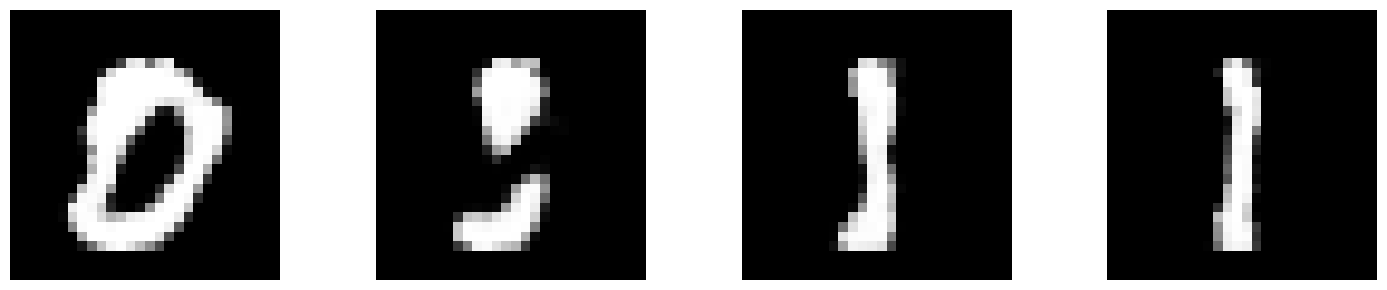

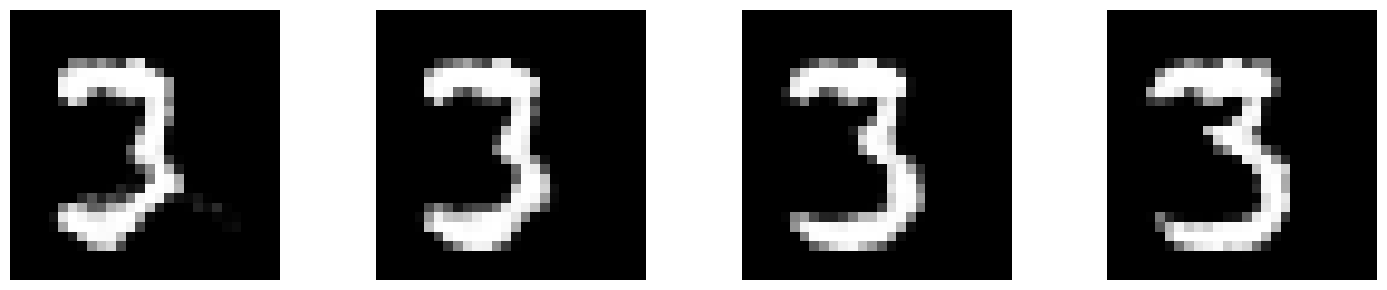

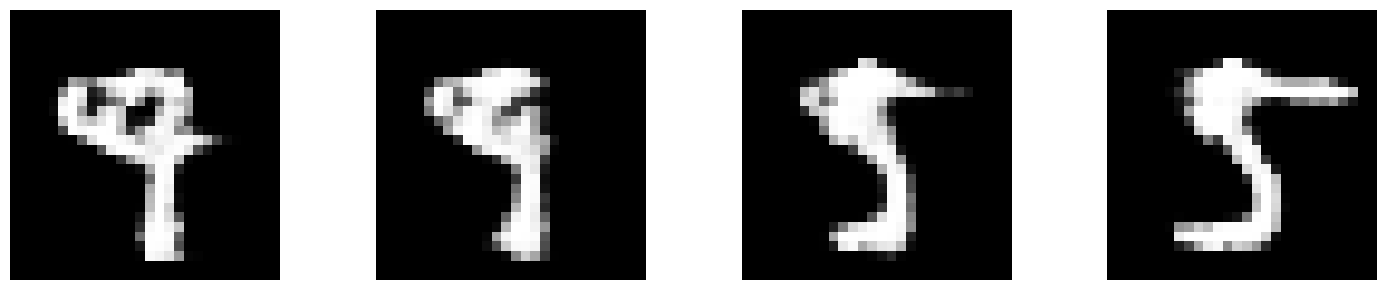

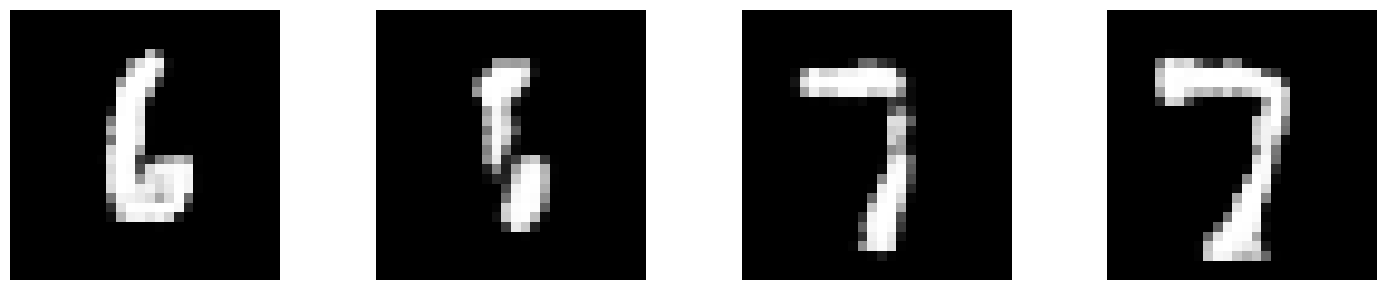

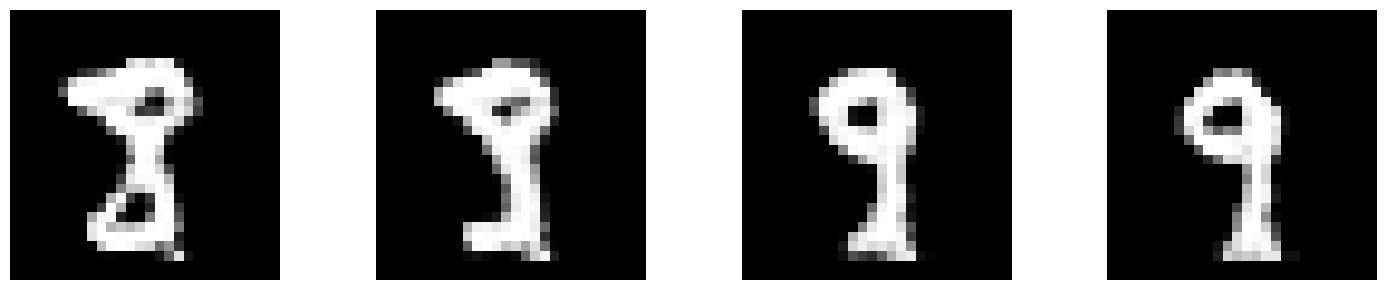

Generated 10000 images and labels, and saved to ../Dataset/NoReg_Extra_1.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 23s 11ms/step - loss: 2.6926 - g_loss: 2.3237 - d_loss: 0.3688
Epoch 2/20
1875/1875 [==============================] - 21s 11ms/step - loss: 2.1579 - g_loss: 1.8379 - d_loss: 0.3200
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.6736 - g_loss: 1.0906 - d_loss: 0.5830
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.5615 - g_loss: 0.9235 - d_loss: 0.6380
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.5185 - g_loss: 0.8673 - d_loss: 0.6513
Epoch 6/20
1875/1875 [==============================] - 21s 11ms/step - loss: 1.4773 - g_loss: 0.8192 - d_loss: 0.6582
Epoch 7/20
1875/1875 [==============================] - 23s 12ms/step - loss: 1.4750 - g_loss: 0.8130 - d_loss: 0.6620
Epoch 8

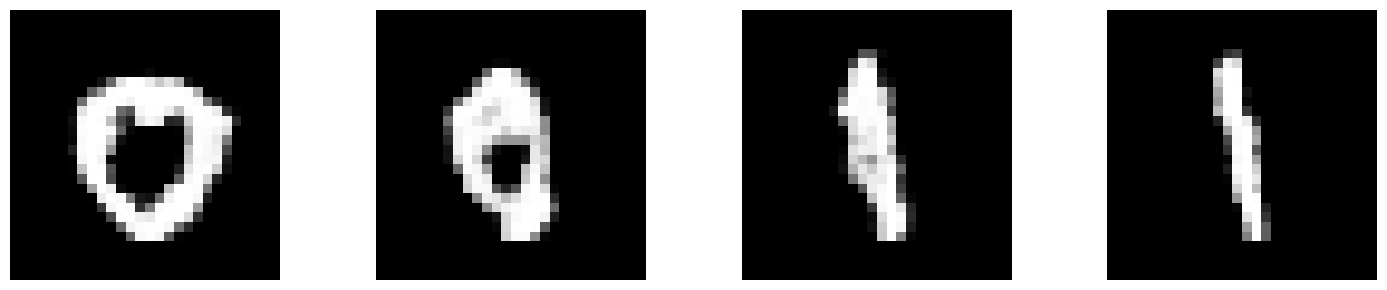

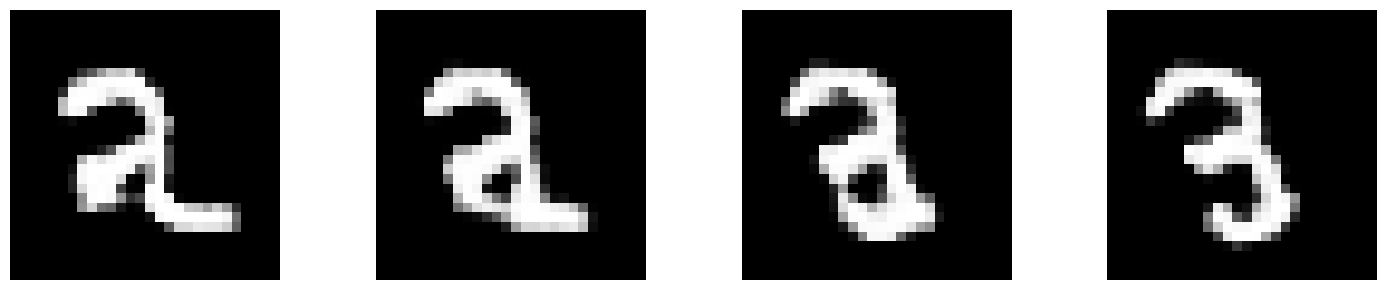

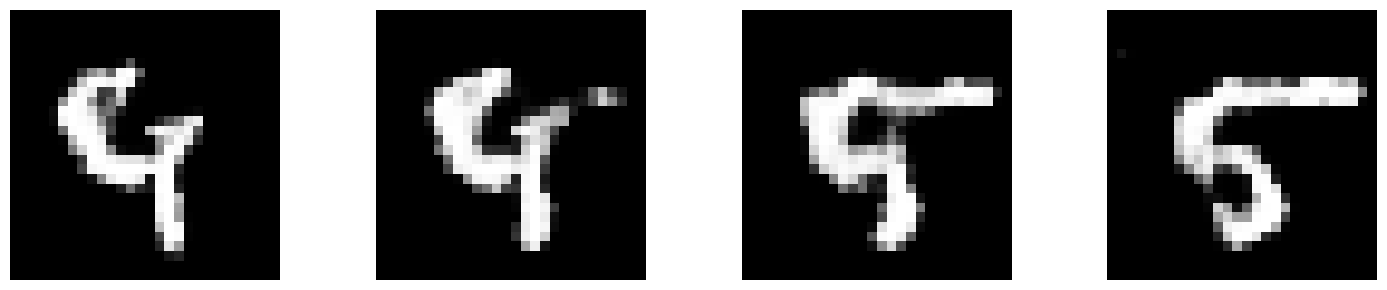

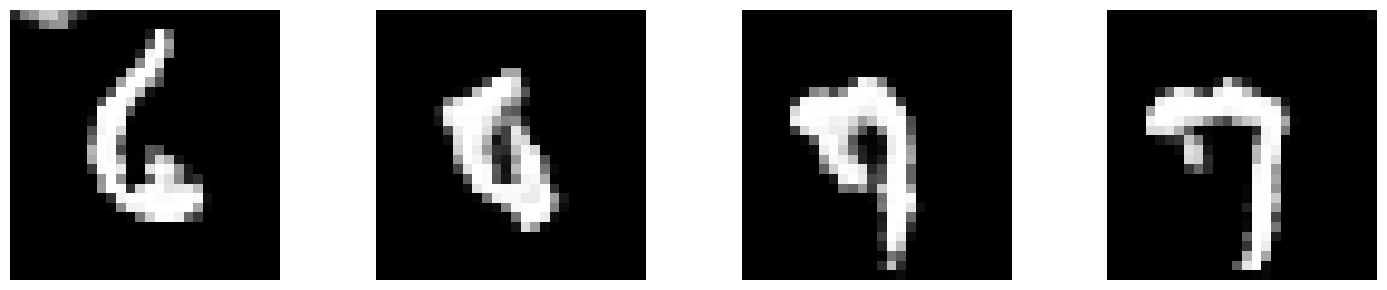

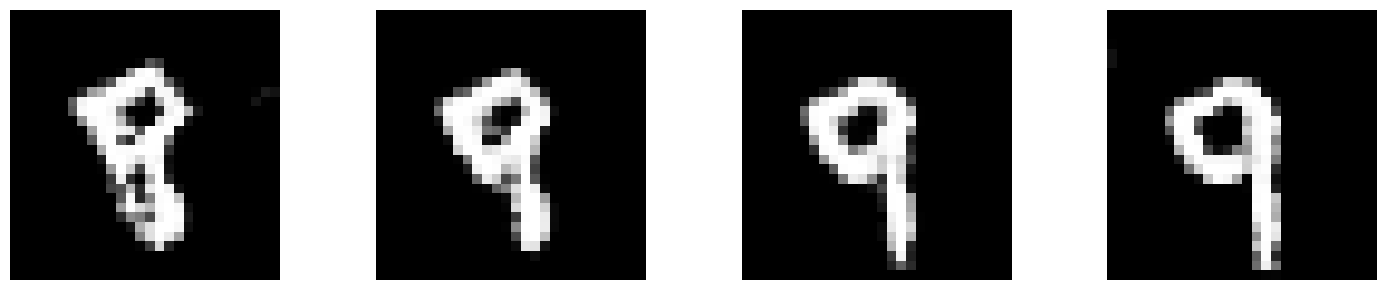

Generated 20000 images and labels, and saved to ../Dataset/NoReg_Extra_2.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 2.5433 - g_loss: 2.1598 - d_loss: 0.3834
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 2.2700 - g_loss: 1.9570 - d_loss: 0.3130
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.7273 - g_loss: 1.1433 - d_loss: 0.5840
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.6441 - g_loss: 1.0264 - d_loss: 0.6177
Epoch 5/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5905 - g_loss: 0.9498 - d_loss: 0.6407
Epoch 6/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5148 - g_loss: 0.8577 - d_loss: 0.6571
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5012 - g_loss: 0.8390 - d_loss: 0.6622
Epoch 8

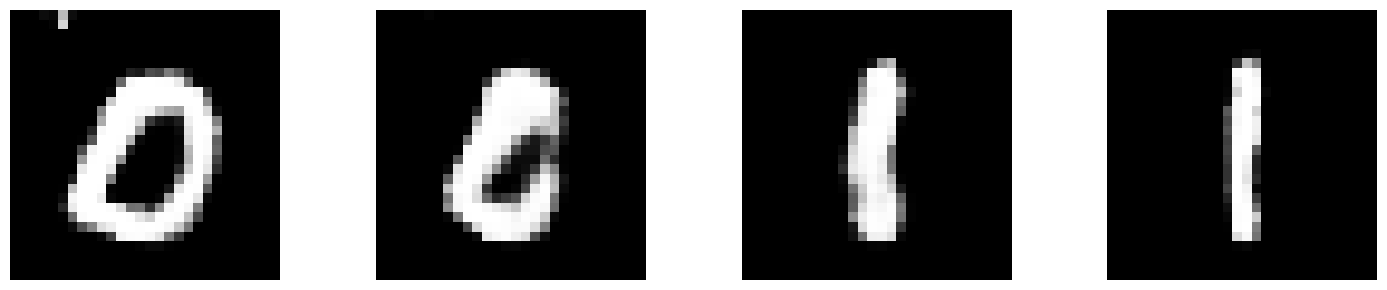

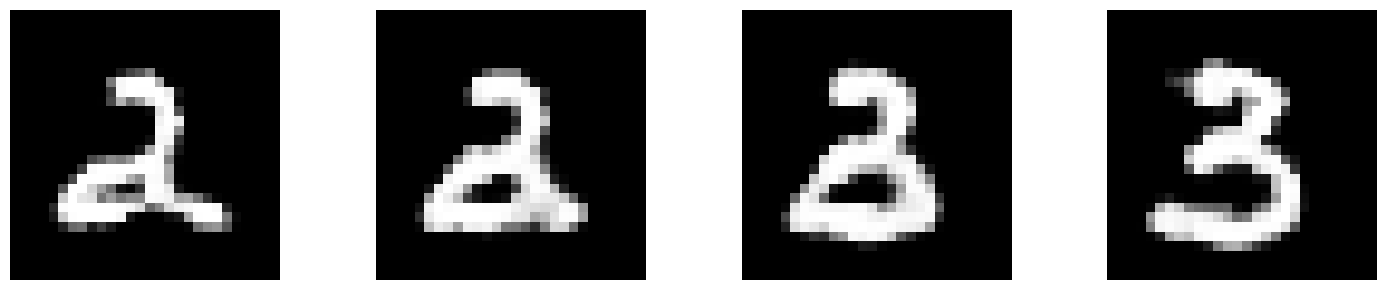

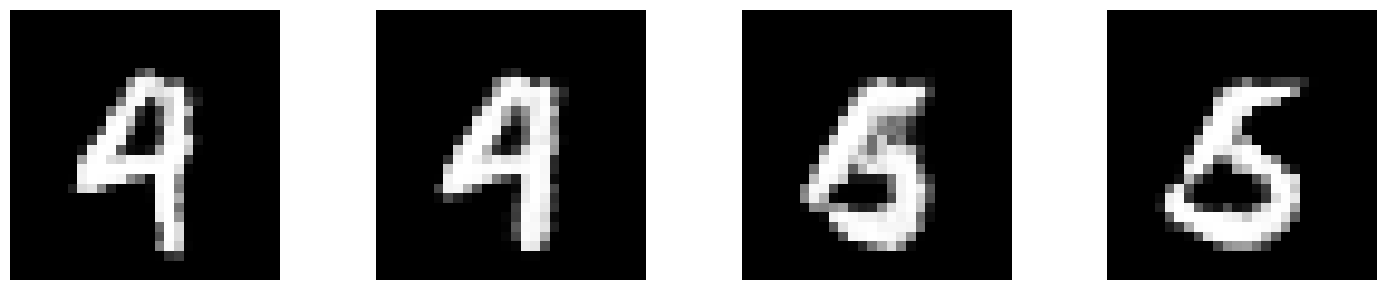

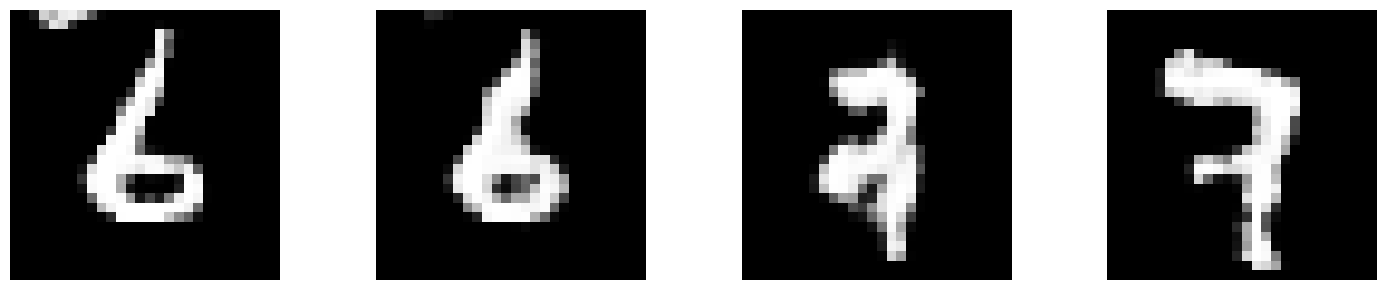

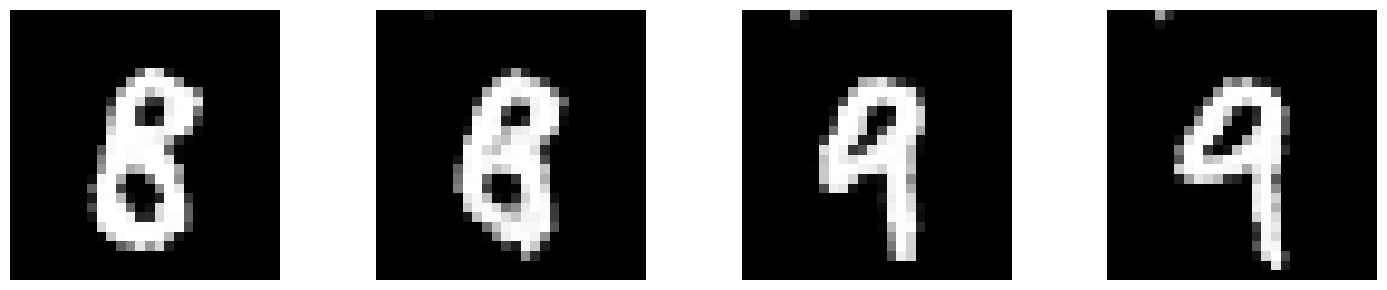

Generated 30000 images and labels, and saved to ../Dataset/NoReg_Extra_3.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 3.0957 - g_loss: 2.7463 - d_loss: 0.3494
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 2.2025 - g_loss: 1.8527 - d_loss: 0.3498
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.6801 - g_loss: 1.0634 - d_loss: 0.6167
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5851 - g_loss: 0.9187 - d_loss: 0.6664
Epoch 5/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5607 - g_loss: 0.8829 - d_loss: 0.6777
Epoch 6/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5216 - g_loss: 0.8463 - d_loss: 0.6752
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.4898 - g_loss: 0.8083 - d_loss: 0.6815
Epoch 8

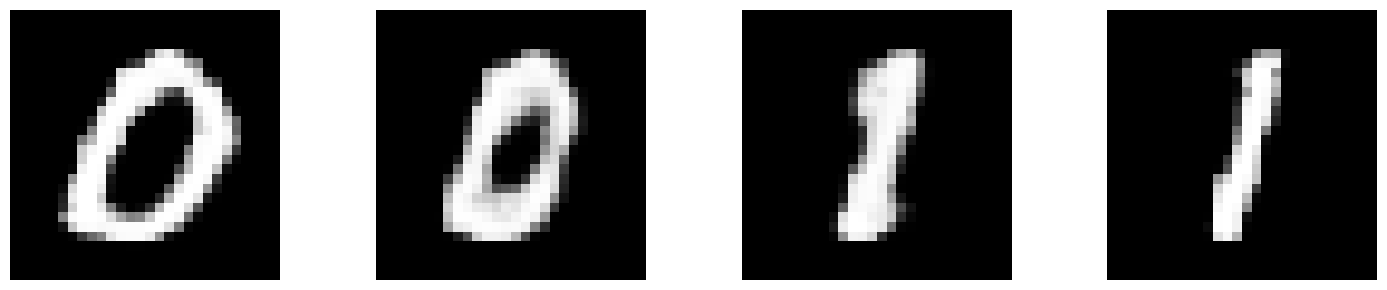

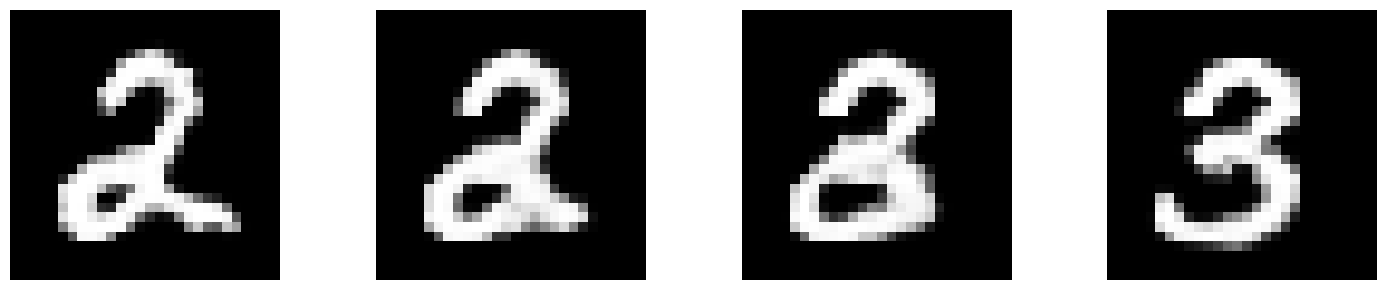

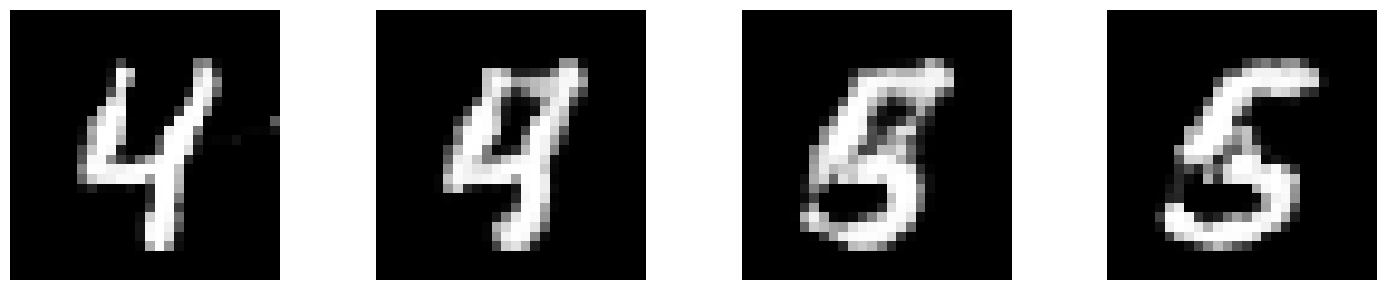

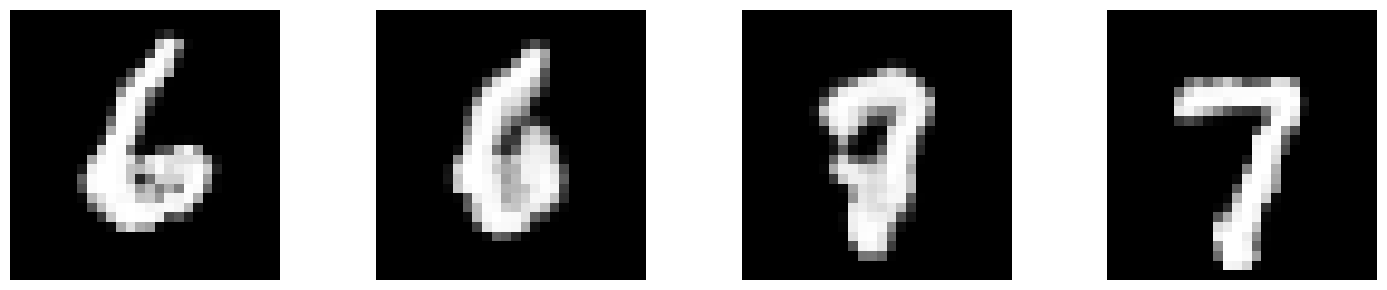

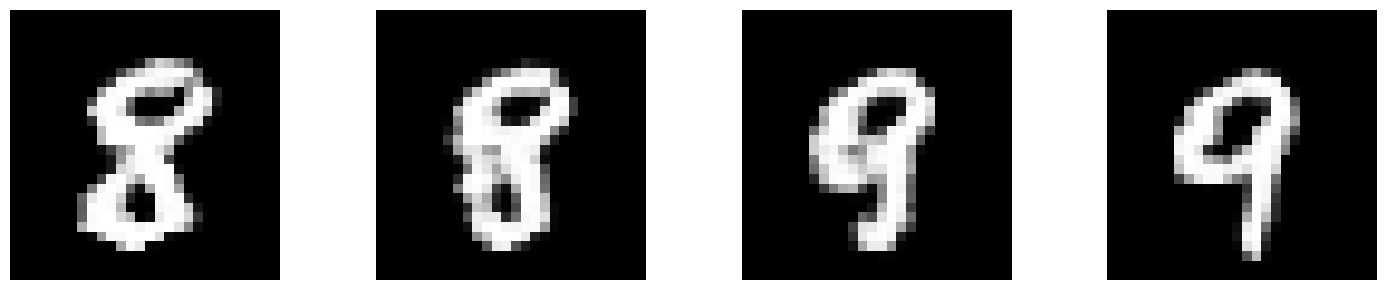

Generated 40000 images and labels, and saved to ../Dataset/NoReg_Extra_4.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 4.7457 - g_loss: 4.5357 - d_loss: 0.2099
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 2.1234 - g_loss: 1.6982 - d_loss: 0.4252
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.9969 - g_loss: 1.4794 - d_loss: 0.5175
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.6771 - g_loss: 1.0263 - d_loss: 0.6507
Epoch 5/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5987 - g_loss: 0.9463 - d_loss: 0.6524
Epoch 6/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5942 - g_loss: 0.9342 - d_loss: 0.6599
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5499 - g_loss: 0.8821 - d_loss: 0.6678
Epoch 8

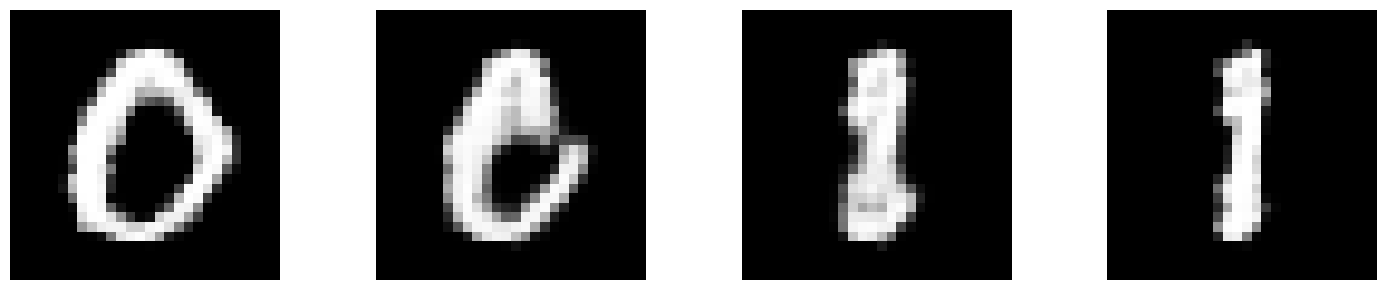

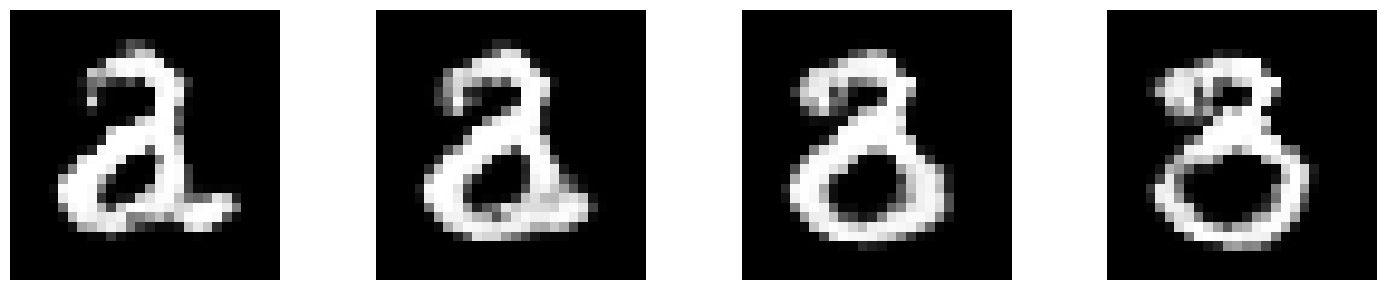

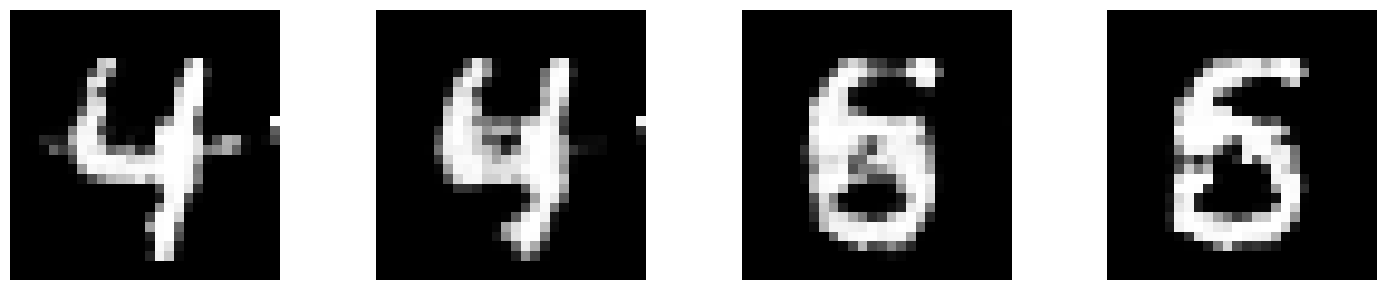

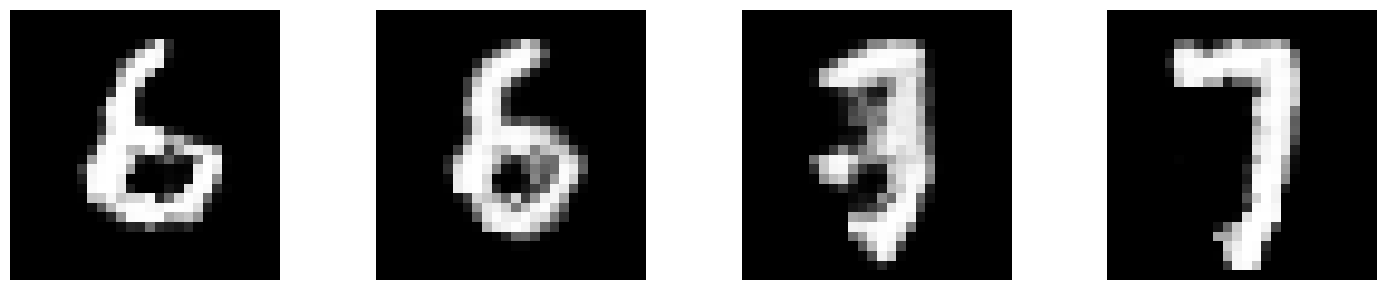

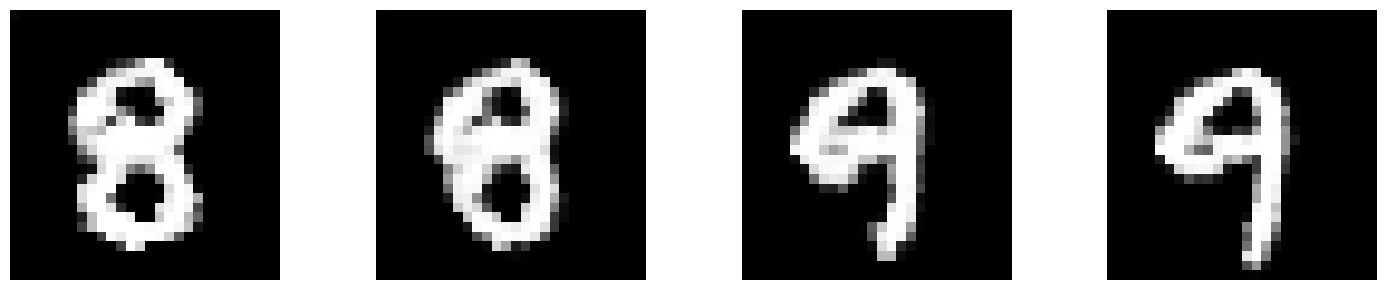

Generated 50000 images and labels, and saved to ../Dataset/NoReg_Extra_5.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 2.7262 - g_loss: 2.3789 - d_loss: 0.3473
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.7948 - g_loss: 1.2433 - d_loss: 0.5514
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.7469 - g_loss: 1.1538 - d_loss: 0.5931
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.6917 - g_loss: 1.0647 - d_loss: 0.6271
Epoch 5/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.6515 - g_loss: 1.0109 - d_loss: 0.6406
Epoch 6/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5385 - g_loss: 0.8330 - d_loss: 0.7055
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 1.5355 - g_loss: 0.8241 - d_loss: 0.7114
Epoch 8

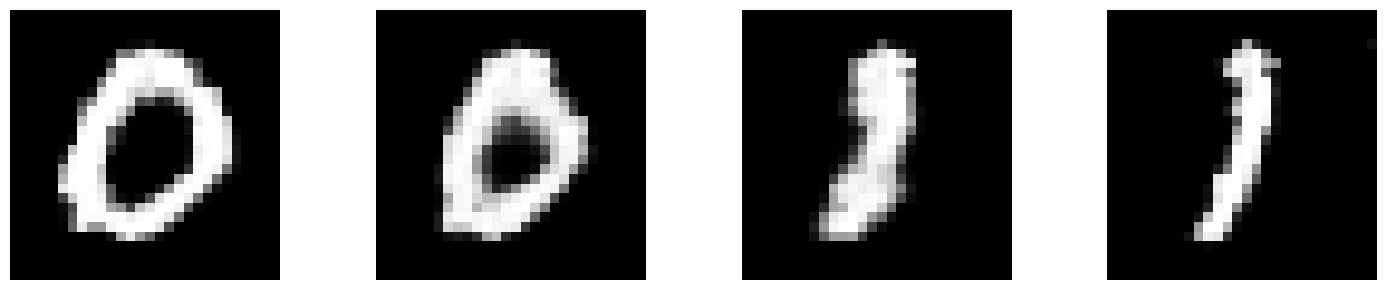

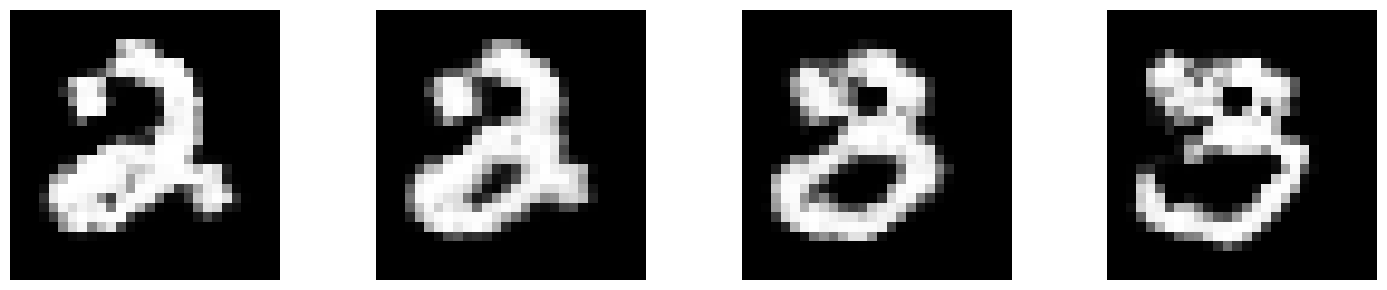

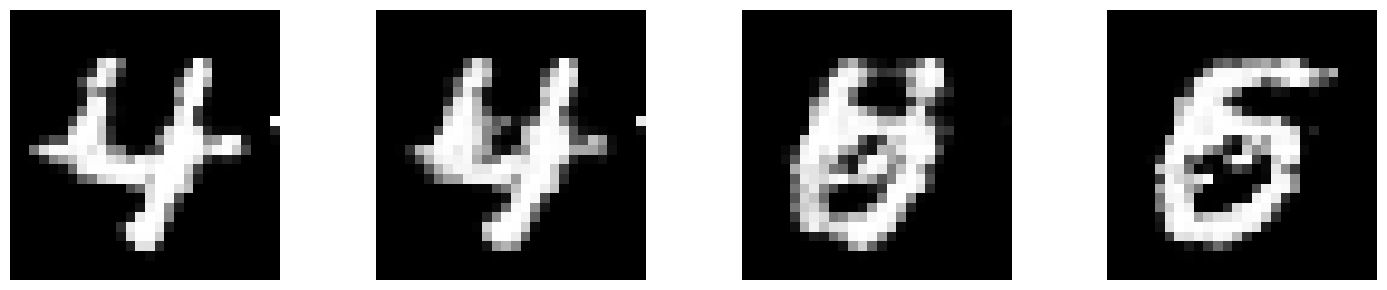

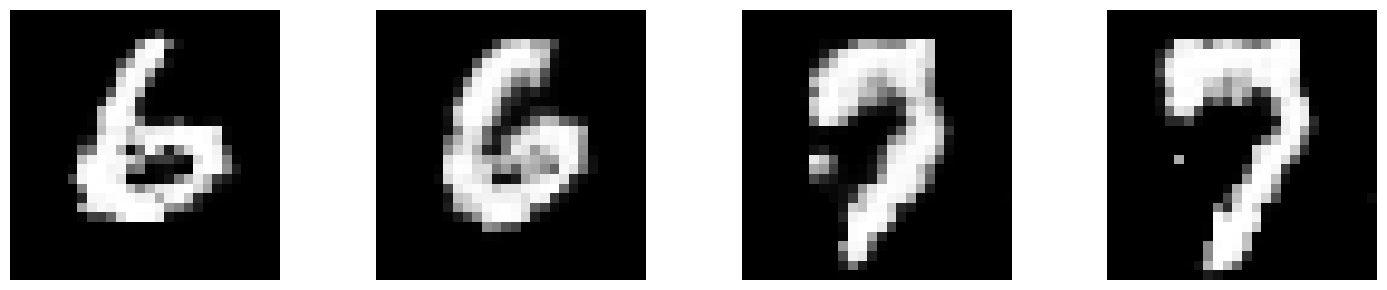

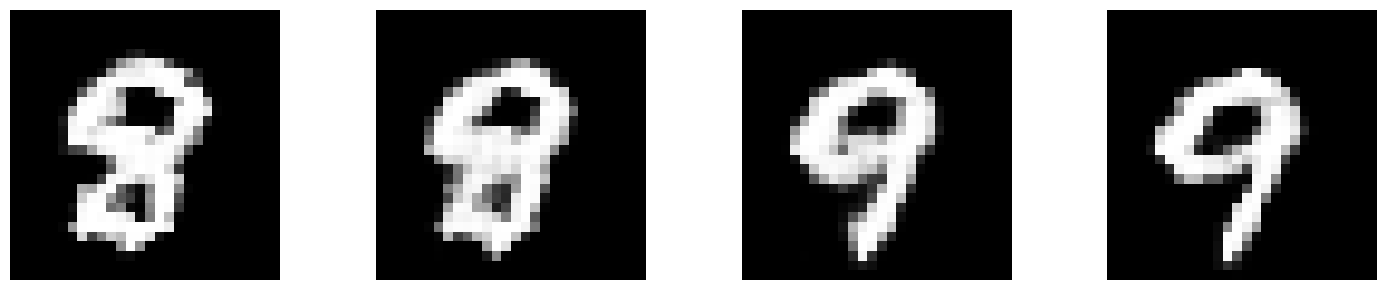

Generated 60000 images and labels, and saved to ../Dataset/NoReg_Extra_6.npz
Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Epoch 1/20


ValueError: in user code:

    File "C:\Users\p.aghaomidi\AppData\Local\miniconda3\envs\KAN-LNN\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\p.aghaomidi\AppData\Local\miniconda3\envs\KAN-LNN\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\p.aghaomidi\AppData\Local\miniconda3\envs\KAN-LNN\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\p.aghaomidi\AppData\Local\Temp\ipykernel_32464\1516341438.py", line 25, in train_step
        image_one_hot_labels = one_hot_labels[:, :, None, None]

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_UINT8, begin_mask=3, ellipsis_mask=0, end_mask=3, new_axis_mask=12, shrink_axis_mask=0](IteratorGetNext:1, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [?], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.


In [9]:
def train_iteration(iteration):
    # Dataset
    train_dataset = prepare_data(iteration=iteration, 
                                 main_path="../Dataset/mnist.npz", 
                                 generated_path=f"../Dataset/NoReg_Extra_{iteration}.npz", 
                                 replace=True)
    
    # Model
    discriminator, generator = get_models()
    cond_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    cond_gan.compile(d_optimizer=opt, g_optimizer=opt, loss_fn=los)
    
    # Train
    cond_gan.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, verbose=1)
    
    # Evaluation
    trained_gen = cond_gan.generator
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    interpolation_noise = tf.repeat(interpolation_noise, repeats=4, axis=0)
    plot_generated_samples(0, 1, 4, interpolation_noise, trained_gen)
    plot_generated_samples(2, 3, 4, interpolation_noise, trained_gen)
    plot_generated_samples(4, 5, 4, interpolation_noise, trained_gen)
    plot_generated_samples(6, 7, 4, interpolation_noise, trained_gen)
    plot_generated_samples(8, 9, 4, interpolation_noise, trained_gen)
    
    # Generation
    generate_and_save_images(trained_gen, 10000*(iteration+1), f"../Dataset/NoReg_Extra_{iteration+1}.npz")
    
for i in range(7):
    train_iteration(i)